# Quality control and alignment

The output of a sequencing machine is a FastQ file.

the format is the following. For every 4 lines we have:
    
    gene id
    RNA sequence
    +
    quality codes
    
Usually all sequences are the same length. We will work for IonProton machinery, which will have different lengths.

## single/paired ends:

For every sequence you have one or two reads -> one or two fastQ files, read from one or both directions.
Every RNA part (300-600 bp) is sequenced for the first 50-150 bp from one or both ends.


## Looking at the general data

Using the [FastQC program](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/). 

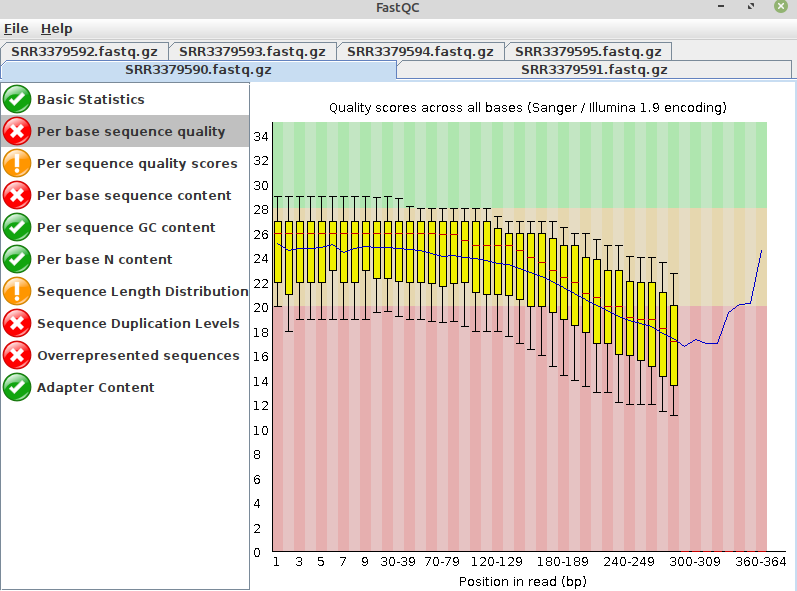

We could trim all sequences after 200 bp, with [Trimmomatic](http://www.usadellab.org/cms/?page=trimmomatic).

Then, we aling it with [STAR](https://github.com/alexdobin/STAR).


We will be working on [this experiment](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE80251). On E.coli, found on GEO (Gene Expression Omnibus) database.  The FastQ UNCOMPRESSED DATA can be downloaded from [this link](https://www.ebi.ac.uk/ena/data/view/PRJNA318398) on ENA (European Nucleotide Archive) database, with the same study code.

The reference genome for that particular E.coli strain (K12 substr MG1655) can be found on [bacteria.ensembl.org](ftp://ftp.ensemblgenomes.org/pub/bacteria/release-45/fasta/bacteria_0_collection/escherichia_coli_str_k_12_substr_mg1655/dna/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.dna.toplevel.fa.gz), that we `gunzip` in the same folder of the fragment files.

GFF3 file is [here](ftp://ftp.ensemblgenomes.org/pub/bacteria/release-45/gff3/bacteria_0_collection/escherichia_coli_str_k_12_substr_mg1655/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.37.gff3.gz). We convert it to a GTF file with `./gffread ../../e.Coli/fastq/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.37.gff3 -T > ../../e.Coli/fastq/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.37.gtf
`

This format is native for STAR.

1) **indexing the genome**:  

`STAR --runMode genomeGenerate --genomeFastaFile <genome folder>  --runThreadN 3 --genomeDir <output folder> --sjdbGTFfile <annotation GTF folter> --genomeSAindexNbases <min(14,log2(genome Lenght)/2-1)) that in our case is 10>`


in this case: `./STAR --runThreadN 4 --genomeFastaFiles ../../../fastq/genome/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.dna.chromosome.Chromosome.fa --runMode genomeGenerate --genomeDir ../../../fastq/output/ --sjdbGTFfile ../../../fastq/genome/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.37.gtf --genomeSAindexNbases 10`

2) **run the analysis** : `/STAR --runThreadN 4 --readFilesCommand zcat  --genomeDir ../../../fastq/output/ --genomeSAindexNbases 10 --readFilesIn ../../../fastq/sequences/SRR3379590.fastq.gz --outFileNamePrefix ../../../fastq/STARoutput/SRR3379590_ --quantMode GeneCounts`

The SAM output file contains the position of the mappings, 1.6 GB. reads, sequence, quality, info on mapping.
[Here are the specifications of the SAM file.](https://samtools.github.io/hts-specs/SAMv1.pdf)

The FLAG field (2nd col) can give a lot of info on data. The information can be deobfuscated with [proper tools](https://broadinstitute.github.io/picard/explain-flags.html).

The MAPQ field is the map quality. A good cutoff is 40. Below there is probably multimapping. 

The CIGAR field is a code to summarize alignment: number + letter:  88M = 88 matches. 21S91M = the first 21 are not aligning (soft-clipped), and 91 matches. 86M1D33M = 86 matches, 1 deletion from the reference, 33 matches. 

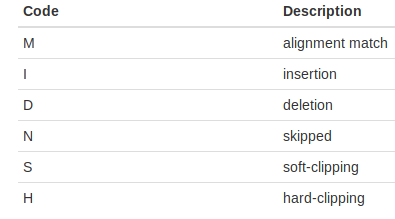

[Link about info on this data format](https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2017/Day1/Session5-alignedReads.html).


    awk '$6!~"N" {print}' SRR3379591_Aligned.out.sam  > SRR3379591_Aligned.out_filtered.sam 
    
To clean away splitted sequences (with an N in the cigar code).

In [1]:
folder = "./e.Coli/fastq/STARoutput/"

In [2]:
library (edgeR)

Loading required package: limma


In [3]:
setwd(folder)
#convert all gene expression counts to data tables, taking only name and third column

In [13]:
wt1 = read.table(file = "SRR3379590_ReadsPerGene.out.tab", sep = "\t")
wt1 = wt1[,c(1,3)]
colnames(wt1) = c("geneid","wt1")

In [14]:
wt2 = read.table(file = "SRR3379591_ReadsPerGene.out.tab", sep = "\t")
wt2 = wt2[,c(1,3)]
colnames(wt2) = c("geneid","wt2")

In [15]:
wt3 = read.table(file = "SRR3379592_ReadsPerGene.out.tab", sep = "\t")
wt3 = wt3[,c(1,3)]
colnames(wt3) = c("geneid","wt3")

In [16]:
tr1 = read.table(file = "SRR3379593_ReadsPerGene.out.tab", sep = "\t")
tr1 = tr1[,c(1,3)]
colnames(tr1) = c("geneid","tr1")

In [17]:
tr2 = read.table(file = "SRR3379594_ReadsPerGene.out.tab", sep = "\t")
tr2 = tr2[,c(1,3)]
colnames(tr2) = c("geneid","tr2")

In [18]:
tr3 = read.table(file = "SRR3379595_ReadsPerGene.out.tab", sep = "\t")
tr3 = tr3[,c(1,3)]
colnames(tr3) = c("geneid","tr3")

In [23]:
# merge data frames

counts = merge (wt1, wt2, by="geneid")
counts = merge (counts, wt3, by="geneid")
counts = merge (counts, tr1, by="geneid")
counts = merge (counts, tr2, by="geneid")
counts = merge (counts, tr3, by="geneid")
head(counts)

geneid,wt1,wt2,wt3,tr1,tr2,tr3
<fct>,<int>,<int>,<int>,<int>,<int>,<int>
b0001,309,122,80,133,62,129
b0002,4213,2541,1096,1449,940,1248
b0003,1492,859,322,676,560,581
b0004,2646,1762,812,923,765,784
b0005,53,49,43,114,108,101
b0006,232,233,254,110,85,95


In [24]:
# assign every experiment to the proper group (control, knockout)

groups = factor (c(1,1,1,2,2,2))

In [29]:
data = DGEList(counts = counts[,2:7], 
               group = groups,
               genes = counts$geneid)

In [32]:
#compute CPM
CPM <- cpm(data)

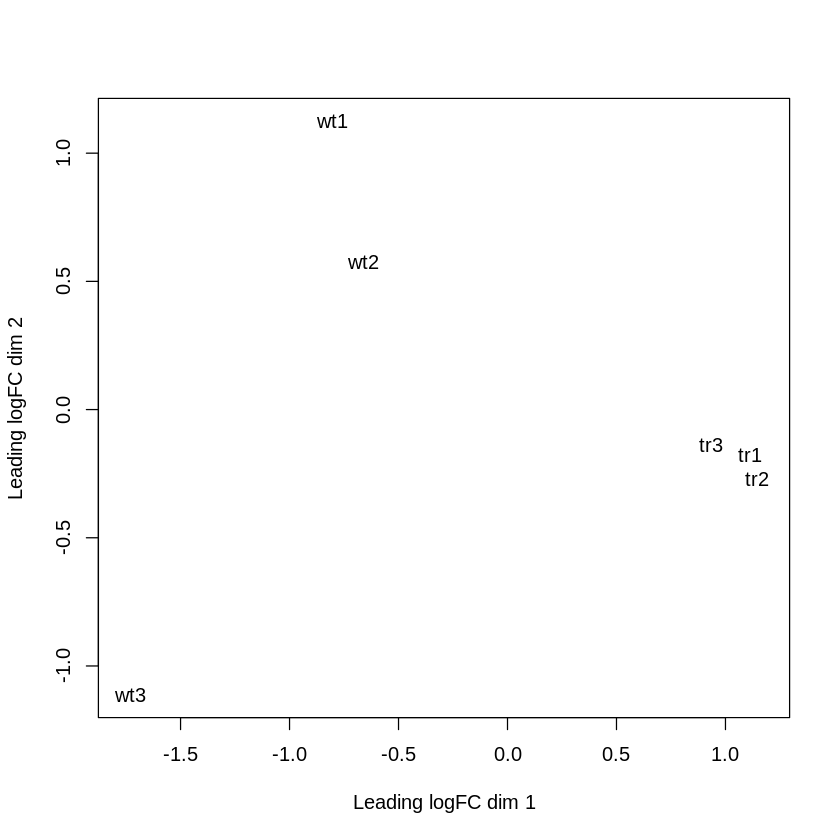

In [53]:
plotMDS(data,method = "logfc")

The samples separates very well on PC space.

         wt1      wt2      wt3      tr1      tr2
wt2 75551.52                                    
wt3 84485.33 32439.46                           
tr1 92440.21 35777.29 55537.15                  
tr2 91929.04 36392.45 59587.61 10080.92         
tr3 87766.44 38052.89 57794.36 16603.55 20233.43

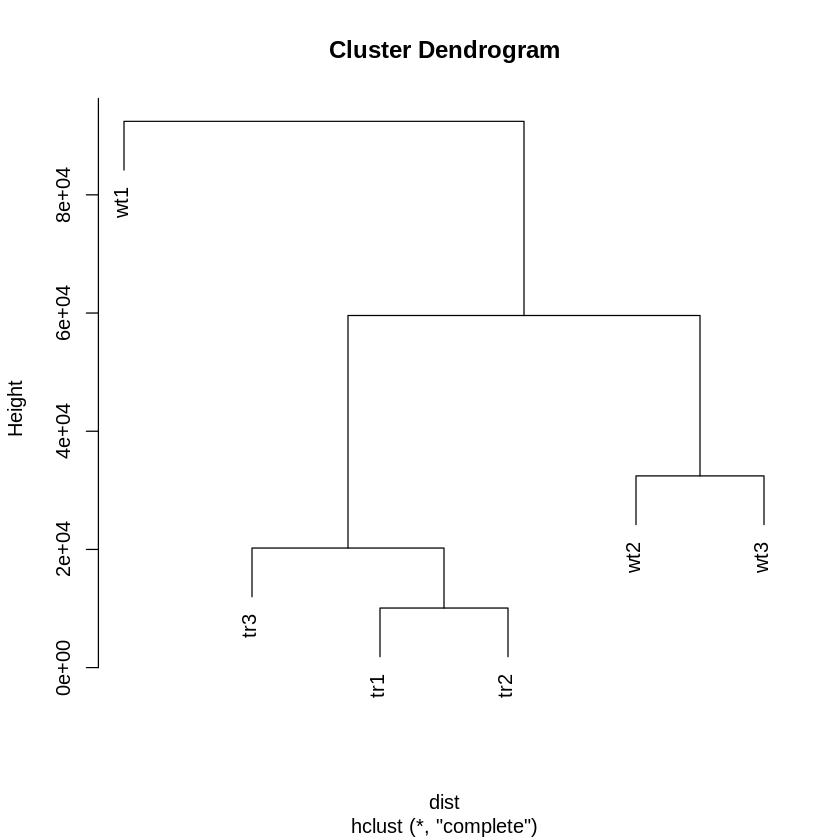

In [51]:

#calculate distance matrix between the experiments
dist <- dist(t(cpm(data)), method = "euclidean")

#clustering distance datas
hclust <- hclust(d = dist)

plot(hclust)

dist

In [57]:
#calculate normalization factors
data = calcNormFactors(object = data)

#create design matrix
design = model.matrix(~groups)

In [58]:
#compute dispersion
data = estimateDisp(data,design)

In [63]:
fit <- glmFit(data)
lrt <- glmLRT(fit)

In [67]:
res <- topTags(lrt, p.value = 0.01, n = 99999999999)
res

,genes,logFC,logCPM,LR,PValue,FDR
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4031,b4307,4.669874,4.916175,130.05512,3.985550e-30,1.793896e-26
3928,b4188,4.032248,5.575372,121.76872,2.593786e-28,5.837315e-25
810,b0871,-3.781331,4.885572,108.69668,1.891209e-25,2.837443e-22
3929,b4189,3.657950,5.524737,107.89472,2.834408e-25,3.189418e-22
4030,b4306,3.336913,4.590023,98.70662,2.928211e-23,2.635975e-20
2812,b3012,-3.410808,4.312828,89.63197,2.868510e-21,2.151861e-18
2501,b2672,-4.195016,3.875675,81.08083,2.166715e-19,1.393198e-16
3594,b3846,4.289840,5.183626,80.01476,3.716228e-19,2.090843e-16
2626,b2801,4.110587,3.018659,77.13900,1.593393e-18,7.968735e-16


In [68]:
dim(res)

[1] 606   6

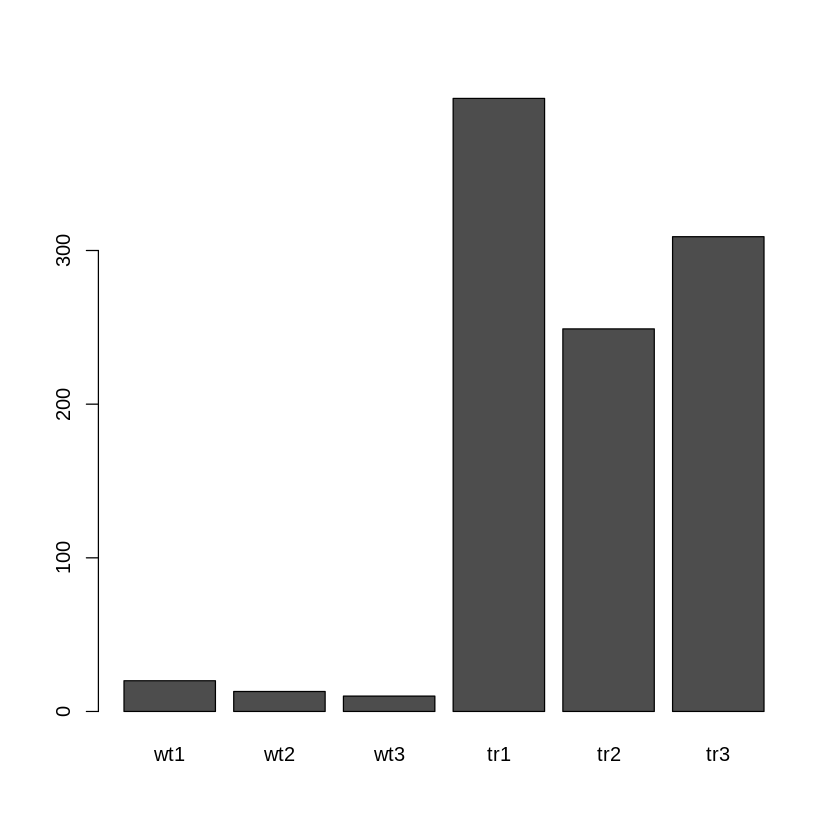

In [74]:
# who is higher than who? who is the real control here?

barplot(as.matrix(counts[counts$geneid=="b4307",2:7]))

Another quality check is made by giving a look by loading the mapping data and physically looking at the results, with [Integrative Genome viewer](http://software.broadinstitute.org/software/igv/). 

## Samtools

converting from SAM to BAM:

    samtools view -S -b SRR3379590_Aligned.out_filtered.sam > SRR3379590.bam

sorting:

    samtools sort SRR3379590.bam -o SRR3379590.sorted.bam
    
indexing: 

    samtools index SRR3379590.sorted.bam

use IGV to open file (hint: edit .sh file to increase available ram from 4g to 12g). Load reference genome, load GFF3 annotation. Expand view.

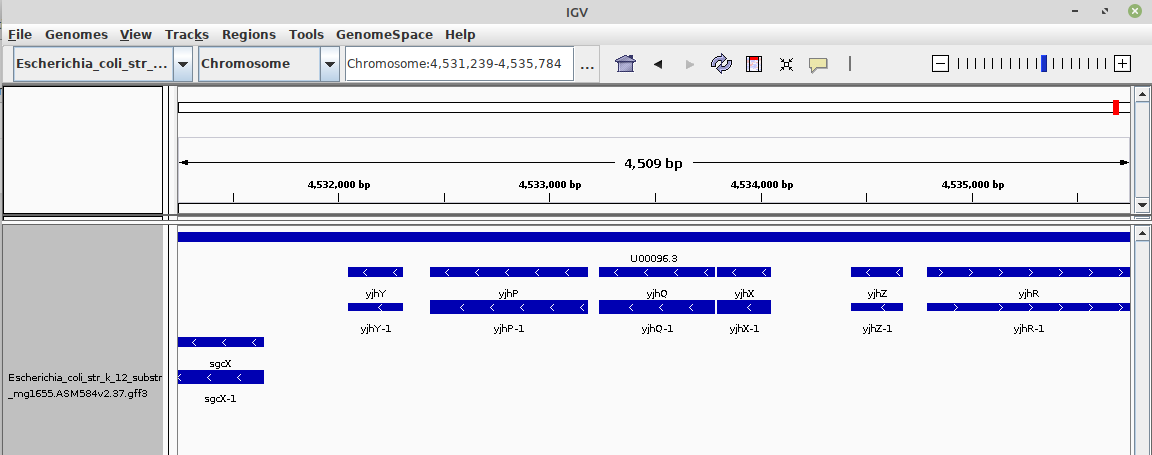

View -> preferences -> Alignments. Limit things before importing BAM files!

1) remove Show mismatched basis
2) remove Label indels
3) filter supplementary alignments and secondary alignments

-> RNA tab:

1) keep only alignment and coverage tracks

Import the BAMs, and select all the BAM tracks, right click, set AutoScale to have the same Y scale in the coverage histogram.